In [1]:
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import multiprocessing as mp

In [2]:
basePath = '../sims.TNG/TNG300-1/output/'
SnapNum = 99

In [3]:
fields=['SubhaloLenType']

In [4]:
subhalos = il.groupcat.loadSubhalos(basePath, SnapNum, fields=fields)

In [5]:
bh_data = [subhalo[5] for subhalo in subhalos]

In [6]:
np.array(bh_data)

array([142,  67,   2, ...,   0,   0,   0], dtype=int32)

In [9]:
nonzero_bh = np.nonzero(bh_data)

In [10]:
nonzero_bh[0]

array([       0,        1,        2, ...,  9621714, 10167240, 10177105])

In [3]:
threshold_mass = 10**10 # Minimum masses of the halos to select

In [4]:
# required_snapshots = [99, 33, 25, 13] # Corresponding to their respective redshifts
# tot_snaps = len(required_snapshots)
# tot_snaps

In [5]:
# redshifts = []
# for i in range(tot_snaps):
#     header = il.groupcat.loadHeader(basePath, required_snapshots[i])
#     redshifts.append(int(header['Redshift']))

In [6]:
# Defining a function for unit conversion
def UnitConversion(array, SnapNum, unit):
    header = il.groupcat.loadHeader(basePath, SnapNum)
    h = header['HubbleParam']
    a = header['Time']
    if unit == 'mass':
        array = array * 1e10 / h # In Msun unit
    if unit == 'length':
        array = array * a / (1e3 * h) # In Mpc unit
    return array

In [7]:
fields = ['Group_M_Crit200', 'GroupFirstSub']

In [8]:
halos = il.groupcat.loadHalos(basePath, SnapNum, fields=fields)

In [9]:
halos_mass = UnitConversion(halos['Group_M_Crit200'], SnapNum, 'mass')
# halos_mass

In [10]:
# Selecting the halos above a certain threshold mass
halo_IDs = np.nonzero(halos_mass >= threshold_mass)
len(halo_IDs[0])

2010258

In [11]:
halo_mass = halos_mass[halo_IDs]

In [12]:
# Extracting the central subhalos of the selected halos
sub_halos_ID = halos['GroupFirstSub'][halo_IDs]
n = len(sub_halos_ID)
n
# sub_halos_ID[-10:]

2010258

In [13]:
def process_subhalo(subhalo_id):
    bh = il.snapshot.loadSubhalo(basePath, SnapNum, subhalo_id, partType=5, fields=['BH_Mass', 'Masses'])
    if bh['count'] > 0:
        return UnitConversion(bh['BH_Mass'][0], SnapNum, 'mass')
    return None

def process_subhalos(subhalo_ids):
    with mp.Pool(10) as pool:
        results = pool.map(process_subhalo, subhalo_ids)
    return results

In [14]:
bh_mass_99 = []

In [15]:
count = 0
chunk_size = 100000
chunks = [sub_halos_ID[i:i + chunk_size] for i in range(0, n, chunk_size)]

for chunk in chunks:
    bh_mass_99 += [mass for mass in process_subhalos(chunk) if mass is not None]
    print(count+1, end=' ')
    count += 1

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 

In [16]:
np.shape(bh_mass_99)

(515161,)

In [17]:
fields = ['SubhaloLenType', 'SubhaloGrNr']

In [18]:
test_sbhalo = il.groupcat.loadSubhalos(basePath, SnapNum, fields=fields)

In [19]:
bh_num = [test[5] for test in test_sbhalo['SubhaloLenType']]

In [20]:
len(bh_num)

14485709

In [21]:
filtered_indices = [i for i in sub_halos_ID if bh_num[i] != 0]

In [22]:
len(filtered_indices)

515161

In [23]:
nonzero_bh_halo_ID = test_sbhalo['SubhaloGrNr'][filtered_indices]

In [24]:
len(nonzero_bh_halo_ID)

515161

In [25]:
halo_mass_99 = halos_mass[nonzero_bh_halo_ID]

In [26]:
len(halo_mass_99)

515161

In [27]:
# fig, ax = plt.subplots(figsize=(18, 10), layout='constrained')

# ax.plot(halo_mass, bh_mass, 'o', markersize=3)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel('M$_{200c}$ [M$_\odot$]', fontsize='large')
# ax.set_ylabel('M$_{SMBH}$ [M$_\odot$]', fontsize='large')
# ax.legend(title='TNG300-1', title_fontsize='medium')

# plt.show()

In [40]:
y_med, _, _, = st.binned_statistic(halo_mass_99, bh_mass_99, statistic='median', bins=7e4)
x_med, _, _, = st.binned_statistic(bh_mass_99, halo_mass_99, statistic='median', bins=7e4)

In [41]:
format(1e5/ 10**0.2, '.3g')

'6.31e+04'

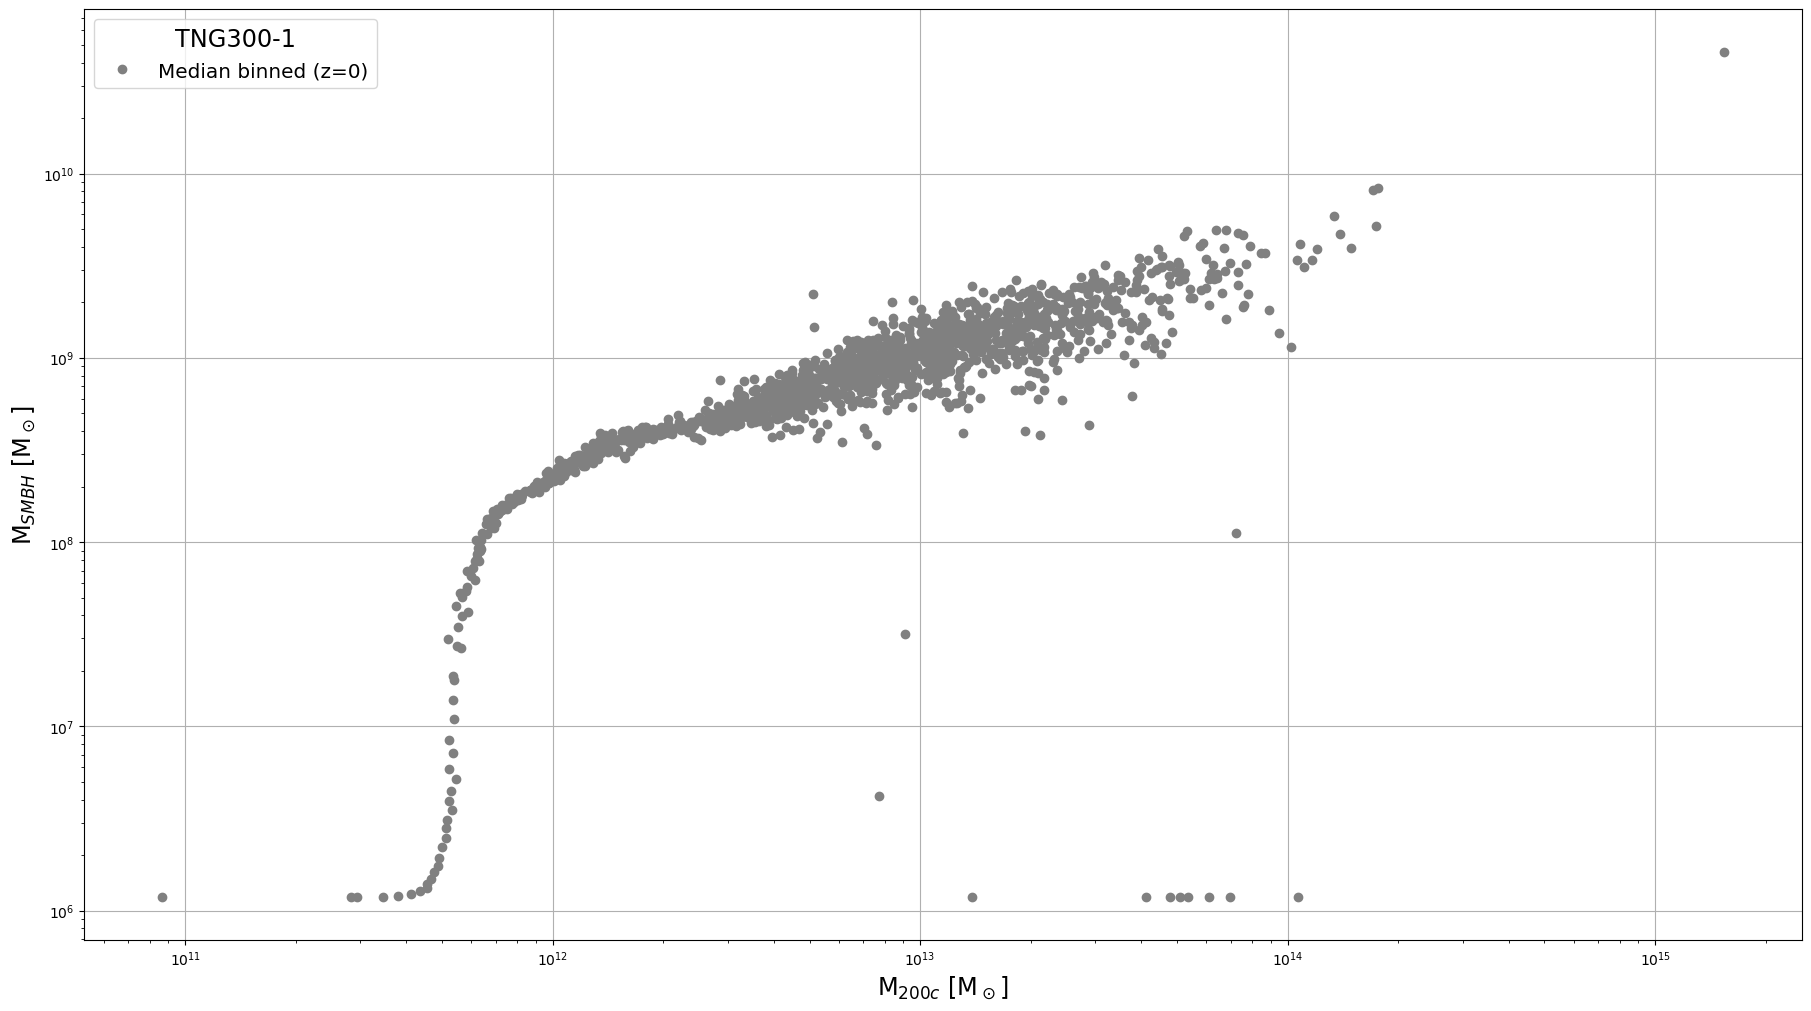

In [45]:
fig, ax = plt.subplots(figsize=(18, 10), layout='constrained')

ax.plot(x_med, y_med, 'o', c='gray', label='Median binned (z=0)')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(right=2e15)
# ax.set_ylim(bottom=5e9)
ax.set_xlabel('M$_{200c}$ [M$_\odot}$]', fontsize='xx-large')
ax.set_ylabel('M$_{SMBH}$ [M$_\odot}$]', fontsize='xx-large')
ax.legend(title='TNG300-1', title_fontsize='xx-large', fontsize='x-large')
plt.grid(True)
plt.savefig('median_binned.png')
plt.show()